In [1]:
################# 正式分析脚本 #################
import pandas as pd
import numpy as np
import os
import re
from typing import List, Optional, Union
from elasticsearch import Elasticsearch
import json

es = Elasticsearch(hosts="10.0.1.107", http_auth=("elastic", "8ec1f622cdc1f07c7b21beeeaf8d21f3"), port=9200, timeout=30, max_retries=3, retry_on_timeout=True)

# 获取文件夹内文件名中包含括号的所有文件
def get_file_paths(folder_path: str) -> List[str]:
    file_paths = []
    for file in os.listdir(folder_path):
        if "(" in file and file.endswith(".xlsx"):
            file_paths.append(os.path.join(folder_path, file))
    return file_paths
def get_file_paths1(folder_path: str) -> List[str]:
    file_paths = []
    for file in os.listdir(folder_path):
        file_paths.append(os.path.join(folder_path, file))
    return file_paths
file_paths = get_file_paths("C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据")
results = []
subject_name = pd.DataFrame({
    "subject_id": [1010, 1011, 1012, 1013, 1014, 1015],
    "subject_name": ["审计","税法", "经济法", "财管", "会计", "战略"],
})
paper_ids = []
for idx, path in enumerate(file_paths):
    df = pd.read_excel(path)
    # 模型得分列识别
    model_score_col = None
    for name in ["AI打分", "系统判分", "程序-用户得分"]:
        if name in df.columns:
            model_score_col = name
            break

    # 最小得分点提取函数
    def extract_min_point(row):
        for json_col in ["AI输出", "结果", "程序判分数据"]:
            if json_col in df.columns and isinstance(row.get(json_col), str):
                try:
                    # json_data = json.loads(row[json_col])
                    corrected_json_str = row[json_col].replace("null", 'None').replace("false", 'False').replace("true", 'True')
                    corrected_json_str1=  re.sub(r'\s+', '', corrected_json_str)
                    json_col_res = eval(corrected_json_str1)
                    data = json_col_res
                    try:
                        question_type = data['question_name']
                        scores = [item['scores']['score'] for item in data['correct_answers_scores'] if 'scores' in item and 'score' in item.get('scores', {})]
                        min_score = min(scores) if scores else None
                        lose_points_messages = []
                        # 提取 correct_answers_scores 中非空的 lose_points
                        for item in data.get('student_scores', []):
                            if 'scores' in item and item['scores'].get('lose_points'):
                                for lp in item['scores']['lose_points']:
                                    if 'message' in lp and 'score' in lp:
                                        lose_points_messages.append(f"{lp['message']}_{lp['score']}")
                        lose_point_res = '|'.join(map(str, lose_points_messages)) if lose_points_messages else ''
                        return min_score, lose_point_res, question_type
                    except KeyError as e:
                        print(corrected_json_str)
                        print(f"Key error: {e}")
                        return None, '', ''
                finally:
                    pass
        pattern = re.compile(r"程序-正确.*分值\d*")
        candidates = [row[col] for col in row.index if pattern.match(col) and pd.notna(row[col])]
        return min(candidates) if candidates else None, '', ''

    df[['最小得分点', '失分原因', "判分类型"]] = df.apply(lambda row: extract_min_point(row), axis=1, result_type='expand')

    # 提取指定列
    parsed = df[["科目ID", "用户ID", "试题ID", "试题分数", "判分类型", "boss-用户得分", model_score_col, "最小得分点", "失分原因"]].copy()
    parsed.columns = ["subject_id", "user_id", "question_id", "question_score", "question_type", "teacher_score", "model_score", "min_point", "lose_points"]
    paper_id_info =  path.rsplit('.', 1)[0].rsplit('_', 1)[-1] # re.search(r'_(\d+?)\(', path)
    if paper_id_info:
        # 提取并打印找到的数字
        paper_id = paper_id_info  # paper_id_info.group(1)
        paper_ids.append(paper_id.split("(")[0])
    else:
        paper_id  = 0
        print(f"无法提取的试卷id是: {path}")
        print("没有找到匹配的数字")
    parsed["paper_id"] = paper_id
    results.append(parsed)

def modify_paper_info(row):
    original_str = row['paper_id']
    subject = row['subject_name']
    
    # 检查是否以 (1), (2), 或 (3) 结尾
    if original_str.endswith('(1)'):
        return original_str + '_初版'
    
    elif subject == '税法':
        if original_str.endswith('(2)'):
            if ("1845665" in original_str) or ("1839417" in original_str):
                return original_str + '_最终版'
            else:
                return original_str + '_正确答案校队'
        elif original_str.endswith('(3)'):
            return original_str + '_修改模型占比'
        # elif not original_str.endswith('('):
        #     return original_str + '第二次月考'
        
    elif subject == '财管':
        if original_str.endswith('(2)'):
            return original_str + '_正确答案校队'
        elif original_str.endswith('(3)'):
            return original_str + '_表格分析+模型优化'
        elif original_str.endswith('(4)'):
            return original_str + '_模型优化'
        # elif not original_str.endswith('('):
        #     return original_str + '第二次月考'
        
    elif subject == '经济法':
        if original_str.endswith('(2)'):
            return original_str + '_纠正正确答案得分'
        elif original_str.endswith('(3)'):
            return original_str + '_最新版'
        # elif not original_str.endswith('('):
        #     return original_str + '第二次月考'
    
    # 如果不满足上述任何条件，则保持原样
    return original_str

final_df = pd.concat(results, ignore_index=True)
final_df = final_df.merge(subject_name, on="subject_id")
final_df.drop(columns=["subject_id"], inplace=True)
final_df['paper_id'] = final_df.apply(modify_paper_info, axis=1)

In [2]:
################# 所有分析函数 ##################
def process_data(data, rule2_quantile=0.95):
    """定义一个通用函数来填充缺失值，并计算三种误差规则"""
    def fill_na_min_point(data):  # 填充缺失的min_point值
        df = data.copy()
        na_rows = df['min_point'].isna()
        for idx in df[na_rows].index:
            qid = df.loc[idx, 'question_id']
            replacement_value = df.loc[df['question_id'] == qid, 'min_point'].dropna().values
            if len(replacement_value) > 0:
                df.at[idx, 'min_point'] = replacement_value[0]
        return df
    df = data.copy()
    df1 = fill_na_min_point(df)
    
    # 计算score_error
    df1['score_error'] = df1.apply(lambda row: row['model_score'] - row['teacher_score'], axis=1)
    
    # 规则1: min(question_score * 0.1, min_point)
    df1['accept_error_rule1'] = df1.apply(lambda row: min(row['question_score'] * 0.1, row['min_point']) if not pd.isna(row['min_point']) else (row['question_score'] * 0.1), axis=1)

    # 规则2: 使用分位数（例如：95%）
    rule2_values = df1.groupby(['subject_name', 'paper_id'])['score_error'].quantile(rule2_quantile)
    df1 = df1.merge(rule2_values.rename('accept_error_rule2'), on=['subject_name', 'paper_id'])
    
    # 规则3: 使用均值加减标准差
    group_stats = df1.groupby(['subject_name', 'paper_id'])['score_error'].agg(['mean', 'std'])
    df1 = df1.merge(group_stats, on=['subject_name', 'paper_id'])
    df1['accept_error_rule3'] = df1.apply(lambda x: ("_").join([str(x['mean'] - x['std']), str(x['mean'] + x['std'])]), axis=1)
    df2 = df1.drop(columns=['mean', 'std'], axis=1)
    return df2

def find_group_id(question_list):
    """查找题目的大题ID"""
    body = {
        "query": {
            "terms": {
                "question_id": question_list
            }
        },
        "_source": ["group_id", "question_id"],
        "size": 10000
    }
    response = es.search(index='biz_question_v2', body=body)
    if response['hits']['total']['value'] == 0:
        return None
    return pd.DataFrame([hit['_source'] for hit in response['hits']['hits']])

def get_group_ques_df(data):
    """从小题层面聚合提取大题层面数据"""
    df = data.copy()
    question_list = df['question_id'].unique().tolist()
    group_df = find_group_id(question_list)
    
    if group_df is not None:
        df1 = df.merge(group_df, on='question_id', how='left')
        df1['group_id'] = df1.apply(
            lambda x: int(x['group_id']) if pd.notna(x['group_id']) else int(x['question_id']),
            axis=1
        )
    else:
        df1 = df.copy()
        df1['group_id'] = df1['question_id'].astype(int)
    
    agg_dict = {
        'question_score': 'sum',
        'question_type': 'unique',
        'teacher_score': 'sum',
        'model_score': 'sum',
        'min_point': 'sum'
    }
    
    df2 = df1.groupby(['subject_name', 'paper_id', 'user_id', 'group_id']).agg(agg_dict).reset_index()
    df2.to_excel('group_ques_df.xlsx', index=False)
    df2.rename(columns={"group_id": "question_id"}, inplace=True)
    df2.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df2.columns.values]
    df2.rename(columns={
        'subject_name_': 'subject_name',
        'paper_id_': 'paper_id',
        'user_id_': 'user_id',
        'question_score_sum': 'question_score',
        'question_type_unique': 'question_type',
        'teacher_score_sum': 'teacher_score',
        'model_score_sum': 'model_score',
        'min_point_sum': 'min_point'
    }, inplace=True)
    
    return df2

def get_paper_name(paper_ids):
    body = {
        "query": {
            "terms": {
                "paper_id": paper_ids
            }
        },
        "_source": ["paper_id", "paper_name"],
        "size": 1000
    }
    response = es.search(index='biz_paper_v2', body=body)
    if response['hits']['total']['value'] == 0:
        return None
    return pd.DataFrame([hit['_source'] for hit in response['hits']['hits']])

def process_dataframe(data, exclude_columns):
    """将结果转换成百分比"""
    data1 = data.copy()
    for col in data1.columns:
        if col not in exclude_columns:
            # 执行乘以100，四舍五入到两位小数
            data1[col] = (data1[col] * 100).round(2)
            # 将结果转换为字符串并加上百分号
            data1[col] = data1[col].astype(str) + '%'
    result = data1.reset_index(drop=True)
    return result

def stats_describe(data):
    """计算误差描述统计量"""
    df = data.copy()
    error_stats_ques = df.groupby(['subject_name', 'paper_id'])['score_error'].agg([
        ('平均误差', 'mean'),
        ('误差中位数', 'median'),
        ('误差标准差', 'std'),
        ('最小误差', 'min'),
        ('最大误差', 'max'),
        ('误差绝对值均值', lambda x: x.abs().mean()),
        ('25%分位数', lambda x: x.quantile(0.25)),
        ('75%分位数', lambda x: x.quantile(0.75)),
        ('95%分位数', lambda x: x.quantile(0.95))
    ]).reset_index(drop=False)
    return error_stats_ques

def calculate_percentage_within_margin(prob: float, group: pd.DataFrame) -> float:
    """计算误差在给定百分比范围内的比例"""
    lower_bound = -prob * group['question_score']
    upper_bound = prob * group['question_score']
    within_margin = ((group['score_error'] >= lower_bound) & (group['score_error'] <= upper_bound))
    return within_margin.mean()

def classify_error(error: float) -> str:
    """分类误差类型"""
    if error == 0:
        return '完全匹配'
    return '模型偏高' if error > 0 else '模型偏低'
    
def is_precise_match(error: float, acceptable_error: Union[float, str], rule_type: int) -> bool:
    """检查是否为精准匹配"""
    if rule_type == 3:
        lower_bound, upper_bound = map(float, acceptable_error.split('_'))
        return lower_bound <= error <= upper_bound
    return -acceptable_error <= error <= acceptable_error

def calculate_percentage_error(row: pd.Series, percentage: float) -> bool:
    """计算误差是否在给定百分比范围内"""
    question_score = row['question_score']
    score_error = row['score_error']
    margin = question_score * percentage / 100.0
    return -margin <= score_error <= margin

def _calculate_common_metrics(grouped_data: pd.core.groupby.generic.DataFrameGroupBy, group_key: List[str]) -> pd.DataFrame:
    """计算通用指标（内部函数）"""
    # 初始化结果DataFrame
    stats = grouped_data.size().reset_index(name='count')
    
    # 计算各类误差比例
    error_classes = grouped_data['error_class'].value_counts(normalize=True).unstack().fillna(0)
    stats = stats.merge(error_classes, left_on=group_key, right_index=True)
    
    # 计算精准匹配的比例（针对三种规则）
    for rule_num in [1, 2, 3]:
        stats[f'精准匹配{rule_num}'] = grouped_data[f'is_precise_match_{rule_num}'].mean().values
    
    # 统计不同误差范围内的比例
    error_ranges = {
        '误差0.5内': (-0.5, 0.5),
        '误差0.8内': (-0.8, 0.8),
        '误差1内': (-1, 1)
    }
    
    for name, (lower, upper) in error_ranges.items():
        stats[name] = grouped_data['score_error'].apply(
            lambda x: ((x >= lower) & (x <= upper)).mean()
        ).values
    
    # 添加误差分值5%、10%、15%内的比例
    for percent in [5, 10, 15]:
        column_name = f'误差分值{percent}%内'
        stats[column_name] = grouped_data.apply(
            lambda g: g.apply(calculate_percentage_error, percentage=percent, axis=1).mean()
        ).values
    
    # stats['老师0分_模型给分'] = grouped_data.apply(
    #     lambda g: ((g['teacher_score'] == 0) & (g['model_score'] > 0)).mean()
    # ).values
    
    # # 新增指标：老师给分但模型打0分的数据占比
    # stats['老师给分_模型0分'] = grouped_data.apply(
    #     lambda g: ((g['teacher_score'] > 0) & (g['model_score'] == 0)).mean()
    # ).values
    
    # # 新增指标：模型0分老师满分占比
    # stats['老师满分_模型0分'] = grouped_data.apply(
    #     lambda g: ((g['teacher_score'] == g['question_score']) & (g['model_score'] == 0)).mean()
    # ).values

    return stats.drop(columns=['count'])

def analyze_paper_scores(data: pd.DataFrame, group_keys) -> pd.DataFrame:
    """分析试卷得分"""
    df = data.copy()
    # 转换数据类型
    df['question_score'] = pd.to_numeric(df['question_score'], errors='coerce')
    df['score_error'] = pd.to_numeric(df['score_error'], errors='coerce')
    
    # 移除无效数据
    df1 = df.dropna(subset=['question_score', 'score_error'])
    
    # 应用分类
    df1['error_class'] = df1['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df1[f'is_precise_match_{rule_num}'] = df1.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷分组并计算指标
    return _calculate_common_metrics(df1.groupby(group_keys), group_keys)

def analyze_by_student_level(data: pd.DataFrame, group_keys) -> pd.DataFrame:
    """按学生试卷分数段水平分析"""
    df = data.copy()
    # 计算每份试卷的满分
    paper_full_scores = df.drop_duplicates(['subject_name', 'paper_id', 'question_id', 'question_score'])\
                         .groupby(['subject_name', 'paper_id'])['question_score'].sum()\
                         .reset_index(name='full_score')
    
    # 合并回原始数据
    df = df.merge(paper_full_scores, on=['subject_name', 'paper_id'])
    
    # 计算每个学生在每份试卷上的总分
    student_scores = df.groupby(['subject_name', 'paper_id', 'user_id']).agg({
        'teacher_score': 'sum',
        'model_score': 'sum',
        'full_score': 'first'
    }).reset_index()
    
    # 划分等级
    def classify_student(row: pd.Series) -> str:
        ratio = row['teacher_score'] / row['full_score']
        if ratio >= 0.6:
            return '60%以上'
        return '30%~60%' if ratio >= 0.3 else '30%以下'
    
    student_scores['level'] = student_scores.apply(classify_student, axis=1)
    
    # 合并等级信息回原始数据
    df = df.merge(student_scores[['subject_name', 'paper_id', 'user_id', 'level']], 
                 on=['subject_name', 'paper_id', 'user_id'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷和等级分组并计算指标
    level_stats = _calculate_common_metrics(df.groupby(group_keys), 
                                           group_keys)
    
    # 将 level 转换为有序分类并排序
    level_order = ['60%以上', '30%~60%', '30%以下']
    level_stats['level'] = pd.Categorical(level_stats['level'], categories=level_order, ordered=True)
    return level_stats.sort_values(group_keys).reset_index(drop=True)

def analysis_question_type(data: pd.DataFrame) -> pd.DataFrame:
    # 按照科目、试卷、题型分析数据量、老师打分模型不打分占比、模型打分老师不打分占比、模型满分老师0分占比、模型0分老师满分占比
    def calculate_group(group):
        return pd.Series({
            '数据量': len(group),
            '老师0分_模型给分': ((group['teacher_score'] == 0) & (group['model_score'] != 0)).mean(),
            '老师给分_模型0分': ((group['teacher_score'] != 0) & (group['model_score'] == 0)).mean(),
            '老师满分模型0分': ((group['teacher_score'] == group['question_score']) & (group['model_score'] == 0)).mean(),
            '老师0分模型满分': ((group['model_score'] == group['question_score']) & (group['teacher_score'] == 0)).mean(),
            '题目最大分值': group['question_score'].max(),
            '题目最小分值': group['question_score'].min(),
            '题目平均分值': group['question_score'].mean(),
            '分差最大值': group['score_error'].max(),
            '分差最小值': group['score_error'].min(),
            '分差均值': group['score_error'].mean()
        })
    df = data.copy()
    result = df.groupby(['subject_name', 'paper_id', 'question_type']).apply(calculate_group)
    result = result.reset_index()
    
    # 格式化：占比类字段转换为百分比字符串
    ratio_columns = [
        '老师0分_模型给分',
        '老师给分_模型0分',
        '老师满分模型0分',
        '老师0分模型满分'
    ]
    for col in ratio_columns:
        result[col] = (result[col] * 100).round(2).astype(str) + '%'

    # 格式化：所有计数类字段为整型
    result['数据量'] = result['数据量'].astype(int)

    # 格式化：所有分数相关字段保留两位小数
    score_columns = [
        '题目最大分值', '题目最小分值', '题目平均分值',
        '分差最大值', '分差最小值', '分差均值'
    ]
    for col in score_columns:
        result[col] = result[col].round(2)
    return result

In [3]:
######## 主流程
def analyze_and_describe(data, group_keys, type = 1):
    """
    分析数据并描述统计数据。
    """
    df = data.copy()
    if type == 1:
        acc_stats = analyze_paper_scores(df, group_keys)
    elif type == 2:
        acc_stats = analyze_by_student_level(df, group_keys)
    stats = stats_describe(df)
    processed_acc_stats = process_dataframe(acc_stats, group_keys)
    return processed_acc_stats, stats

# step1：数据处理--误差计算
final_df1 = process_data(final_df)
final_group_df1 = process_data(get_group_ques_df(final_df))

# step2：准确率计算
ques_acc_stats, error_stats_ques = analyze_and_describe(final_df1, ['subject_name', 'paper_id'])
group_acc_stats, error_stats_group = analyze_and_describe(final_group_df1, ['subject_name', 'paper_id'])
level_acc_stats, _ = analyze_and_describe(final_df1, ['subject_name', 'paper_id', "level"], type = 2)
ques_type_acc_stats, _ = analyze_and_describe(final_df1, ['subject_name', 'paper_id', "question_type"])
ques_type_stats = analysis_question_type(final_df1)

In [4]:
# 对数据进行一定的清洗过滤后计算准确率
# step1：先筛选每个科目最新的一份试卷数据
sub_paper_newest = ques_acc_stats[['subject_name',"paper_id"]].drop_duplicates()
sub_paper_newest1 = sub_paper_newest.copy()
sub_paper_newest1['paper_id_info'] = sub_paper_newest1['paper_id'].str.split('(', n=1).str[0]
sub_paper_newest2 = sub_paper_newest1[~(sub_paper_newest1['paper_id'].str.contains('千问', na=False))].groupby(
    ['subject_name', 'paper_id_info']).apply(lambda x: x.sort_values('paper_id', ascending=False).head(1))
qianwen_paper = sub_paper_newest1[sub_paper_newest1['paper_id'].str.contains('千问', na=False)]

# step2: 根据一定的规则对数据进行过滤
def filter_and_process_data(df_raw, paper_range, condition):
    """
    根据给定条件过滤数据并处理。
    """
    df_case = df_raw.copy()
    df_case1 = df_case[df_case['paper_id'].isin(paper_range)].reset_index(drop=True)
    if condition:
        # 筛选规则1：财管中表格类型、模型判0分的数据踢掉、删除某个表格题3728171
        df_deal = df_case1.copy()

        # 构建过滤条件
        exclude_question_ids = [] #3728171, 3728165, 3788647, 3788711, 3788735
        df_filtered = df_deal[~df_deal['question_id'].isin(exclude_question_ids)]
        
        # 筛选规则2：战略中lose_points为“正确答案已经全部匹配”的数据误差改为0
        df_filtered1 = df_filtered.copy()
        df_filtered1['is_correct_fitted'] = df_filtered1.apply(lambda x: 1 if ('正确答案已经全部匹配' in x['lose_points'] and x['subject_name'] == '战略') else 0, axis=1)
        
        # 筛选规则3：模型判分高于试题分数都修改为试题分数
        df_filtered2 = df_filtered1.copy()
        df_filtered2['model_score'] = df_filtered2.apply(lambda x: x['question_score'] if x['model_score'] > x['question_score'] else x['model_score'], axis=1)

        # 筛选规则3：错误类型只包含单位错误的数据的误差改为0
        def check_unit_error_only(lose_points):
            # 使用正则表达式匹配仅包含“单位错误”的情况
            if re.fullmatch(r'(?:单位错误_.+?)(?:\|单位错误_.+?)*', lose_points):
                return 1
            else:
                return 0
        df_filtered3 = df_filtered2.copy()
        df_filtered3["is_unit_error"] = df_filtered3['lose_points'].apply(check_unit_error_only)

        # 筛选规则4：学生答案中score、student_score都为0分但echo_txt不为空的数据代表步骤分
        
        # 修改符合筛选规则数据的误差值        
        df_filtered3['model_score'] = df_filtered3.apply(lambda x: x['teacher_score'] if x['is_correct_fitted'] == 1 or x['is_unit_error'] == 1 else x['model_score'], axis=1)
        df_filtered_res = df_filtered3.drop(columns=['is_correct_fitted', 'is_unit_error'], axis=1).reset_index(drop=True)
    else:
        df_filtered_res = df_case1.copy()
    return df_filtered_res

# step3: 计算准确率
paper_range = sub_paper_newest2['paper_id'].unique().tolist() # + qianwen_paper['paper_id'].unique().tolist()
df_clean = filter_and_process_data(final_df, paper_range, condition=True)
final_df1_adj = process_data(df_clean)
final_group_df1_adj = process_data(get_group_ques_df(df_clean))
ques_acc_stats_adj, error_stats_ques_adj = analyze_and_describe(final_df1_adj, ['subject_name', 'paper_id'])
group_acc_stats_adj, error_stats_group_adj = analyze_and_describe(final_group_df1_adj, ['subject_name', 'paper_id'])
level_acc_stats_adj, _ = analyze_and_describe(final_df1_adj, ['subject_name', 'paper_id', "level"], type = 2)
ques_type_acc_adj, _ = analyze_and_describe(final_df1_adj, ['subject_name', 'paper_id', "question_type"])
ques_type_stats_adj = analysis_question_type(final_df1_adj)

In [5]:
# 比较清洗数前后的结果并做相关处理
def format_colored(row, col):
    # 合并数据：left join 保留原始顺序
    raw_val = row[col]
    filtered_val = row[f"{col}_filtered"]
    if pd.isnull(filtered_val):
        return raw_val  # 没有过滤后数据

    # 转换为数值（去掉百分号）
    raw_num = float(str(raw_val).replace('%', ''))
    filtered_num = float(str(filtered_val).replace('%', ''))

    # 比较并添加颜色
    if abs(raw_num - filtered_num) < 1e-6:
            return raw_val  # 无变化

    color = "green" if filtered_num > raw_num else "red"
    return f'{raw_val} <span style="color:{color}">（{filtered_val}）</span>'

def merge_more_accurate(raw_data, filter_data, type = 1):
    df_raw = raw_data.copy()
    df_filter = filter_data.copy()
    
    if type == 1:
        key_cols = ['subject_name', 'paper_id']
    elif type == 2:
        key_cols = ['subject_name', 'paper_id', 'level']
    elif type == 3:
        key_cols = ['subject_name', 'paper_id', 'question_type']
    df_merged = df_raw.merge(df_filter, on=key_cols, suffixes=('', '_filtered'), how='left')

    # 拼接百分比字段
    accuracy_cols = [col for col in df_raw.columns if col not in key_cols]

    # 应用格式化
    for col in accuracy_cols:
        df_merged[col] = df_merged.apply(lambda row: format_colored(row, col), axis=1)

    # 保留最终列
    df_final = df_merged[key_cols + accuracy_cols]
    return df_final

ques_acc_stats_raw = ques_acc_stats[ques_acc_stats['paper_id'].isin(paper_range)].copy()
group_acc_stats_raw = group_acc_stats[group_acc_stats['paper_id'].isin(paper_range)].copy()
level_acc_stats_raw = level_acc_stats[level_acc_stats['paper_id'].isin(paper_range)].copy()
ques_type_stats_raw = ques_type_acc_stats[ques_type_acc_stats['paper_id'].isin(paper_range)].copy()

ques_acc_compare = merge_more_accurate(ques_acc_stats_raw, ques_acc_stats_adj)
group_acc_compare = merge_more_accurate(group_acc_stats_raw, group_acc_stats_adj)
level_acc_compare = merge_more_accurate(level_acc_stats_raw, level_acc_stats_adj, type = 2)
ques_type_compare = merge_more_accurate(ques_type_stats_raw, ques_type_acc_adj, type = 3)

In [6]:
# 统计各科目最后准确率：完全匹配、精准匹配1 + 计算类型有分差的数据（百分之5%误差）
def data_classify_error(data):
    df = data.copy()
    # 转换数据类型
    df['question_score'] = pd.to_numeric(df['question_score'], errors='coerce')
    df['score_error'] = pd.to_numeric(df['score_error'], errors='coerce')
    
    # 移除无效数据
    df = df.dropna(subset=['question_score', 'score_error'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    return df

def cal_final_acc(raw_data, subject_name, paper_id):
    df = data_classify_error(raw_data)
    
    # 计算各科目的误判情况
    df1 = df[(df['subject_name'] == subject_name) & (df['paper_id'] == paper_id)]
    data_in_precise1 = df1[df1['is_precise_match_1'] == 1]
    data_out_precise1 = df1[df1['is_precise_match_1'] == 0]  # 精准匹配1之外的数据

    if "1840085" in paper_id:
        selected_by_see = str(round(39/len(df1)*100, 2)) + "%"
    elif "1836223" in paper_id:
        selected_by_see = "3.56%"
    elif "1845665" in paper_id:
        selected_by_see = str(round(5/len(df1)*100, 2)) + "%"
    elif "1843481" in paper_id:
        selected_by_see = str(round(43/len(df1)*100, 2)) + "%"
    elif "1848189" in paper_id:
        selected_by_see = str(round(136/len(df1)*100, 2)) + "%"
    elif "1848395" in paper_id:
        selected_by_see = str(round(125/len(df1)*100, 2)) + "%"
    elif "1849552" in paper_id:
        selected_by_see = str(round(56/len(df1)*100, 2)) + "%"
    elif "1850037" in paper_id:
        selected_by_see = str(round(83/len(df1)*100, 2)) + "%"
    elif "1851211" in paper_id:
        selected_by_see = str(round(116/len(df1)*100, 2)) + "%"
    else: 
        selected_by_see = "/"

    if (subject_name == '战略') or (subject_name == '会计'):
        return len(df1), "/", selected_by_see
    
    elif subject_name == '经济法':
        data_out_precise1_1 = data_out_precise1.copy()
        data_out_precise1_1['select_1'] = data_out_precise1_1.apply(
            lambda x: 1 if (x['teacher_score']==x['question_score']) and (x['model_score'] < x['teacher_score']) and (x['model_score'] == 1.5) else 0,
            axis=1
        )
        data_out_precise1_1['select_2'] = data_out_precise1_1.apply(
            lambda x: 1 if ((x['teacher_score'] / x['question_score']) == 0.5) and (x['model_score'] == 0.5) else 0,
            axis=1
        )
        data_out_precise1_cal1 = data_out_precise1_1[(data_out_precise1_1['select_1'] == 1) | (data_out_precise1_1['select_2'] == 1)]
        cal_prob = round(len(data_out_precise1_cal1) / len(df1) * 100, 2)
        return len(df1), str(cal_prob) + '%', selected_by_see
    
    elif subject_name == '财管':
        data_out_precise1_cal1 = data_out_precise1[data_out_precise1['question_type'] == '计算']
        data_out_precise1_cal2 = data_out_precise1[(data_out_precise1['question_type'] == '观点+计算') &
                                                    (data_out_precise1['model_score'] == 0) &
                                                    (data_out_precise1['teacher_score'] > 0)]
        data_out_precise1_cal3 = data_out_precise1[data_out_precise1['question_type'].str.contains('表格')]
        cal_prob = round((len(data_out_precise1_cal1) + len(data_out_precise1_cal2) + len(data_out_precise1_cal3)) / len(df1) * 100, 2)
        return len(df1), str(cal_prob) + '%', selected_by_see
    
    elif subject_name == '税法':
        data_out_precise1_cal1 = data_out_precise1[data_out_precise1['question_type'] == '计算']
        cal_prob = round(len(data_out_precise1_cal1) / len(df1) * 100, 2)
        return len(df1), str(cal_prob) + '%', selected_by_see

# 每个科目选取最新的一份清洗后的数据, 根据规则计算误判率

# paper_final_case = ['1822327(1)_初版', '1836221(3)_修改模型占比', '1836223(3)_最新版', '1828837(3)_表格分析+模型优化', '1835723(3)_表格分析+模型优化']
# count_res = ques_acc_stats_adj[ques_acc_stats_adj["paper_id"].isin(paper_final_case)][["subject_name", "paper_id", "完全匹配", "精准匹配1"]]
count_res = ques_acc_stats_adj[["subject_name", "paper_id", "完全匹配", "精准匹配1"]]
count_acc_res = count_res.copy()
count_acc_res[['数据量', '老师误判[程序筛选]', '老师误判[人工筛选]']] = count_acc_res.apply(lambda x: pd.Series(cal_final_acc(final_df1_adj, x['subject_name'], x['paper_id'])), axis=1)
count_acc_res1 = count_acc_res.copy().reset_index(drop=True)
count_acc_res1 = count_acc_res1[['subject_name', 'paper_id', '数据量', '完全匹配', '精准匹配1', '老师误判[程序筛选]', '老师误判[人工筛选]']]
count_acc_res1['最终准确率'] = count_acc_res1.apply(
    lambda x: x['精准匹配1'] if (x['老师误判[程序筛选]'] == "/") & (x['老师误判[人工筛选]'] == "/")
    else (str(round(float(x['精准匹配1'].replace('%', ''))  + float(x['老师误判[程序筛选]'].replace('%', '')), 2)) + "%") if (x['老师误判[程序筛选]'] != "/") & (x['老师误判[人工筛选]'] == "/")
    else (str(round(float(x['精准匹配1'].replace('%', ''))  + float(x['老师误判[人工筛选]'].replace('%', '')), 2)) + "%") if (x['老师误判[程序筛选]'] == "/") & (x['老师误判[人工筛选]'] != "/")
    else (str(round(float(x['精准匹配1'].replace('%', ''))  + float(x['老师误判[人工筛选]'].replace('%', '')) + float(x['老师误判[程序筛选]'].replace('%', '')), 2)) + "%"), axis=1)
# 拼接试卷名称
paper_ids_info= list(set(paper_ids))
paper_name_info = get_paper_name(paper_ids_info)
# paper_name 提取》后面 和（前的内容
paper_name_info['paper_name1'] = paper_name_info["paper_name"].apply(lambda x: x.split("》")[1].split("（")[0])
paper_name_res = paper_name_info[["paper_id", "paper_name1"]].drop_duplicates().reset_index(drop=True)
paper_name_res["paper_id"] = paper_name_res["paper_id"].astype(int)

count_acc_res1_1 = count_acc_res1.copy()
count_acc_res1_1['paper_id1'] = count_acc_res1_1['paper_id'].apply(lambda x: int(x.split("(")[0]))
count_acc_res2 = pd.merge(count_acc_res1_1, paper_name_res, left_on='paper_id1', right_on='paper_id', how='left')
count_acc_res2.drop(columns=['paper_id1', 'paper_id_y'], inplace=True)
count_acc_res2.rename(columns={'paper_id_x': 'paper_id', 'paper_name1': 'paper_name'}, inplace=True)
count_acc_res2.rename(columns={'paper_name': '试卷名称'}, inplace=True)
count_acc_res2 = count_acc_res2[['subject_name', '试卷名称', 'paper_id', '数据量', '完全匹配', '精准匹配1', '老师误判[程序筛选]',
       '老师误判[人工筛选]', '最终准确率']]

# subject select one paper
paper_select = count_acc_res1_1.groupby("subject_name")["paper_id1"].idxmax()
paper_id_select = count_acc_res1_1.loc[paper_select, "paper_id"]
count_acc_res3 = count_acc_res2[count_acc_res1['paper_id'].isin(paper_id_select)].copy()
count_acc_res3.reset_index(drop=True, inplace=True)

In [7]:
# 统计试卷基本情况（题目数量，总记录条数， 题目最大分值、题目最小分值、题目均分）
def paper_base_info(df, paper_range):
    df_case = df[df['paper_id'].isin(paper_range)].copy()
    # Step 1: 计算基础指标
    basic_stats = df_case.groupby(['subject_name', 'paper_id']).agg(
        total_records=('question_id', 'count'),
        # unique_users=('user_id', 'nunique'),
        unique_questions=('question_id', 'nunique')
    ).reset_index()
    
    # Step 2: 去重题目数据并计算分数统计
    unique_questions_df = df_case[['subject_name', 'paper_id', 'question_id', 'question_score']].drop_duplicates()
    score_stats = unique_questions_df.groupby(['subject_name', 'paper_id']).agg(
        avg_question_score=('question_score', 'mean'),
        max_question_score=('question_score', 'max'),
        min_question_score=('question_score', 'min')
    ).reset_index()
    
    # Step 3: 合并两个结果集
    final_stats = pd.merge(basic_stats, score_stats, on=['subject_name', 'paper_id'])
    final_stats.columns = ['科目名称', '试卷ID', '数据量', '题目数量', '题目平均分值', '题目最高分值', '题目最低分值']
    return final_stats

ques_base_count = paper_base_info(final_df1, paper_range)
group_base_count = paper_base_info(final_group_df1, paper_range)

In [8]:
# 定义表格数据html格式处理函数
from IPython.display import HTML
import pandas as pd

def styled_group_table(
    df: pd.DataFrame,
    subject_col: str = '科目名称',
    dedup_cols: list = None, 
    table_id: str = 'dataTable'
) -> str:
    # 确保不会修改原始 df
    df1 = df.copy()
    if dedup_cols is None:
        dedup_cols = [subject_col]
    
    # 1. 计算分组边界（按dedup_cols）
    subject_series = df1[subject_col]
    is_last_of_subject = subject_series != subject_series.shift(-1)  # 科目分组的最后一行
    
    # 2. 计算去重边界（用于清除重复值）
    dedup_keys = df1[dedup_cols].apply(tuple, axis=1)
    is_first_of_dedup = dedup_keys != dedup_keys.shift(1)  # 去重组的第一行
    
    # 3. 清除重复值（保留每组的第一个值）
    for col in dedup_cols:
        df1.loc[~is_first_of_dedup, col] = ''

    # 4. 生成HTML
    html = f"""
    <style>
        th, td {{ text-align: center; padding: 6px; }}
        th {{ border-bottom: 2px solid black; }}
        .subject-end td {{ border-bottom: 2px solid #333; }}  /* 科目分组的最后一行加粗下边框 */
        table {{ border-collapse: collapse; width: 100%; margin-top: 10px; }}
    </style>
    <table id="{table_id}">
        <thead>
            <tr>{"".join(f"<th>{col}</th>" for col in df1.columns)}</tr>
        </thead>
        <tbody>
    """
    
    # 5. 逐行生成表格
    for i in range(len(df1)):
        row = df1.iloc[i]
        row_class = "subject-end" if is_last_of_subject.iloc[i] else ""
        
        # 添加 data-subject 属性（用于筛选）
        subject_attr = f'data-subject="{df.iloc[i][subject_col]}"'
        
        html += f"""
            <tr class="{row_class}" {subject_attr}>
                {"".join(f"<td>{row[col]}</td>" for col in df1.columns)}
            </tr>
        """
    
    html += """
        </tbody>
    </table>
    """
    return html

def format_floats_smart(df: pd.DataFrame, skip_cols=2) -> pd.DataFrame:
    df1 = df.copy()
    num_cols = df1.select_dtypes(include='number').columns.tolist()
    format_cols = df1.columns[skip_cols:]  # 从第 skip_cols 列之后开始格式化

    for col in format_cols:
        if col in num_cols:
            df1[col] = df1[col].apply(lambda x: f"{x:.3f}".rstrip('0').rstrip('.') if pd.notnull(x) else '')
    return df1

def process_dataframe(df, skip_cols=2):
    """统一处理数据框：格式化浮点数并重命名列"""
    formatted_df = format_floats_smart(df, skip_cols=skip_cols)
    formatted_df.rename(columns={'subject_name': '科目名称', 'paper_id': '试卷ID'}, inplace=True)
    return formatted_df

def wrap_with_subject_filter(html_table: str, table_id: str, subjects: list, title: str = "") -> str:
    """给表格添加科目过滤器（使用 select2 实现美观多选）"""
    filter_options = '\n'.join([f'<option value="{subj}">{subj}</option>' for subj in subjects])
    
    return f"""
<div class="table-section">
    <h3>{title}</h3>
    <label for="filter-{table_id}">选择科目：</label>
    <select id="filter-{table_id}" class="subject-filter" multiple>
        <option value="">全部科目</option>
        {filter_options}
    </select>
    {html_table}
</div>
"""

In [9]:
########## 表格html结果 #########
dataframes = {
    "html_ques_base": (ques_base_count, 2),
    "html_group_base": (group_base_count, 2),
    'html_ques_error': (error_stats_ques[error_stats_ques['paper_id'].isin(paper_range)], 2),
    'html_group_error': (error_stats_group[error_stats_group['paper_id'].isin(paper_range)], 2),
    'html_ques_acc': (ques_acc_stats, 2),
    'html_group_acc': (group_acc_stats, 2),
    'html_ques_type_stats': (ques_type_stats, 3),
    'html_level_acc': (level_acc_stats, 3),
    'compare_ques_acc': (ques_acc_compare, 2),
    'compare_group_acc': (group_acc_compare, 2),
    'compare_ques_type_stats': (ques_type_compare, 3),
    'compare_level_acc': (level_acc_compare, 3),
    'final_acc_res': (count_acc_res2, 3)
}

# 使用字典推导式处理所有数据框
processed_dataframes = {name: process_dataframe(df, skip_cols) for name, (df, skip_cols) in dataframes.items()}

# 对 html_base_info 使用多列分组，其他表格使用单列分组
processed_html = {}
for name, df in processed_dataframes.items():
    if "ques_type" in name or "level" in name:
        # 按 ['科目名称', '试卷ID'] 分组
        processed_html[name] = styled_group_table(
                df=processed_dataframes[name],
                subject_col="科目名称",
                dedup_cols=["科目名称", "试卷ID"],  # 按这两列清除重复值
                table_id=name
            )
    else:
        # 默认按 ['科目名称'] 分组
        processed_html[name] = styled_group_table(
                df=processed_dataframes[name],
                subject_col="科目名称",
                table_id=name
            )

# 构建最终HTML列表
table_html_list = [
    "<h2 id='base_desc'>试卷基本情况描述统计</h2>",
    "<p>下面是关于各科目各试卷从小题和大题两个层面下一些基本情况的统计。</p>",
    wrap_with_subject_filter(
        processed_html['html_ques_base'],
        table_id='html_ques_base',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="小题层面"
    ),
    wrap_with_subject_filter(
        processed_html['html_group_base'],
        table_id='html_group_base',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="大题层面"
    ),

    "<h2 id='error_desc'>试卷整体误差描述统计</h2>",
    "<p>下面表格是从小题和大题（如果多个小题同属于一个大题，大题的模型打分和老师打分为对应小题分数之和）两个层面统计的关于老师打分和模型打分之间分差的描述统计量</p>",
    wrap_with_subject_filter(
        processed_html['html_ques_error'],
        table_id='html_ques_error',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="小题层面"
    ),
    wrap_with_subject_filter(
        processed_html['html_group_error'],
        table_id='html_group_error',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="大题层面"
    ),
    
    "<h2 id='acc_desc'>判分准确性各项指标</h2>",
    """<div class="description">
        <p>下方表格呈现的是从多个角度统计的模型判分准确性指标，其中精准匹配1/2/3是根据一下三种规则得到一个误差合理值或者误差合理范围，然后统计的分差在对应误差范围内的数据占比。规则如下：<br>
           <b>规则1：取题目最小得分点和该题目分值的10%两者之间的最小值；<br>
           规则2：分差的百分之95%分位数；<br>
           规则3：获取分差均值和标准差，计算均值正负一个标准差范围。</b></p>

        <p>下方表格中呈现了两版数据的结果。一版是原始数据，一版是经过下述筛选条件对数据做清洗后的结果。<br>
        黑色代表两版数据准确率没有差异，红色代表清洗后数据的准确率下降，绿色代表清洗后数据的准确率上升。<br>
           <b>筛选条件1：图片题不支持，删除指定的图片题数据；<br>
           筛选条件2：如果某个小题错误类型都是单位错误，暂时认定该题目模型打分和老师判分没分差；<br>
           筛选条件3：战略中有错误类型包含“正确答案已经全部匹配”字样，暂时认定该题目模型打分和老师判分没分差；<br>
           筛选条件4：模型判分结果超过题目原始分值的统一修改为原始分值（判分规则不一致）。</b></p>
    </div>""",
     wrap_with_subject_filter(
        processed_html['compare_ques_acc'],
        table_id='compare_ques_acc',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="小题层面"
    ),
    wrap_with_subject_filter(
        processed_html['compare_group_acc'],
        table_id='compare_group_acc',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="大题层面"
    ),

    "<h2 id='score_level_desc'>分数段层面准确率</h2>",
    """<div class="description">
        <p>下方表格呈现的是不同分数段水平上各科目准确性指标结果。</p>
    </div>""",
    wrap_with_subject_filter(
        processed_html['compare_level_acc'],
        table_id='compare_level_acc',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="分数段层面（小题层面统计）"
    ),

    "<h2 id='ques_type_desc'>题型层面准确率</h2>",
    """<div class="description">
        <p>下方表格呈现的是从各科目的题型层面来看每个题型下准确率情况、分差来源分布情况。</p>
    </div>""",
    wrap_with_subject_filter(
        processed_html['compare_ques_type_stats'],
        table_id='compare_ques_type_stats',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="题型层面打分情况描述（小题层面统计）"
    ),

    "<h2 id='final_desc'>最终准确率结果（小题层面）</h2>",
    """<div class="description">
        <p>以下结果是展示的每个科目最新版数据在经过数据清洗后得到的完全匹配和精准匹配1结果，老师误判是根据各科目给到的一些规则对精准匹配范围外的数据进行统计得到的结果。<br>
        <b>最终准确率可参考：精准匹配1比例 + 老师误判(程序筛选+人工筛选)比例 。</b><br>
           税法误判情况1：题型为纯计算的题，统一认为模型判分没问题；<br>
           经济法误判情况1：老师打满分，模型打分小于老师分且模型打分为1.5分，认为模型判分无误；<br>
           经济法误判情况2：老师打分为题目分值的一半，模型打分为0.5分，认为模型判分无误；<br>
           财管误判情况1：题型里面带"表格"的题，统一认为模型判分无误；<br>
           财管误判情况2：题型为纯计算的题，统一认为模型判分没问题；<br>
           财管误判情况3：题型为观点+计算且模型判0分老师给分，认为这类题老师给的是步骤分，模型暂时不给步骤分，暂定模型判分无误。</p>
    </div>""",
     wrap_with_subject_filter(
        processed_html['final_acc_res'],
        table_id='final_acc_res',
        subjects=["会计", "战略", "税法", "经济法", "财管"],
        title="小题层面"
    ),
]

In [10]:
########### 绘图相关函数 ##########
import matplotlib.pyplot as plt
from IPython.display import HTML
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec

matplotlib.rcParams['font.family'] = ['SimHei']           # 使用黑体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False         # 正确显示负号

def create_kde_plot(ax, data, title, STYLE):
    """通用KDE绘图函数"""
    if not data.empty:
        for role in ['teacher', 'model']:
            color, label = STYLE['colors'][role]
            sns.kdeplot(data[f'{role}_score'], ax=ax, 
                        label=label, color=color, 
                        fill=True, warn_singular=False)
        ax.set_title(title, fontsize=STYLE['subtitle_fontsize'])
        ax.set_xlabel("得分", fontsize=STYLE['label_fontsize'])
        ax.set_ylabel("密度", fontsize=STYLE['label_fontsize'])
        ax.legend(fontsize=STYLE['legend_fontsize'])
        ax.tick_params(axis='both', labelsize=STYLE['tick_fontsize'])
    else:
        ax.axis('off')

def build_grid_plot(df, groupby_col, title, filename, STYLE, output_dir):
    """通用网格绘图函数"""
    # 准备数据
    subjects = sorted(df['subject_name'].unique())
    group_dict = {
        subj: sorted(df[df['subject_name'] == subj][groupby_col].unique())
        for subj in subjects
    }
    max_cols = max(len(v) for v in group_dict.values())
    
    # 创建画布
    fig = plt.figure(
        figsize=(STYLE['col_width'] * max_cols, 
                STYLE['row_height'] * len(subjects)),
        constrained_layout=True
    )
    outer = gridspec.GridSpec(
        len(subjects), 1, 
        height_ratios=[1]*len(subjects), 
        hspace=STYLE['hspace']
    )

    # 绘制子图
    for row_idx, subject in enumerate(subjects):
        groups = group_dict[subject]
        inner = gridspec.GridSpecFromSubplotSpec(
            1, len(groups), 
            subplot_spec=outer[row_idx], 
            wspace=STYLE['wspace']
        )
        
        for k, group_val in enumerate(groups):
            ax = plt.Subplot(fig, inner[k])
            sub_df = df[(df['subject_name'] == subject) & 
                        (df[groupby_col] == group_val)]
            
            # 动态生成标题
            if groupby_col == 'paper_id':
                plot_title = f"{subject} | 试卷: {group_val} | n={len(sub_df)}"
            elif groupby_col == 'question_score':
                plot_title = f"{subject} | 满分 {group_val} 分\nn={len(sub_df)}"
            else:
                plot_title = f"{subject} | 题型: {group_val}\nn={len(sub_df)}"
            
            create_kde_plot(ax, sub_df, plot_title, STYLE)
            fig.add_subplot(ax)

    plt.suptitle(title, fontsize=STYLE['title_fontsize'], y=0.98)
    plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])
    return output_dir / filename


C:\Users\xxxlll\AppData\Local\Temp\ipykernel_38528\321953378.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

✅ 报告已生成：C:\Users\xxxlll\Desktop\东奥\subjective_judge_score\report_output\report.html


c:\Users\xxxlll\AppData\Local\conda\conda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


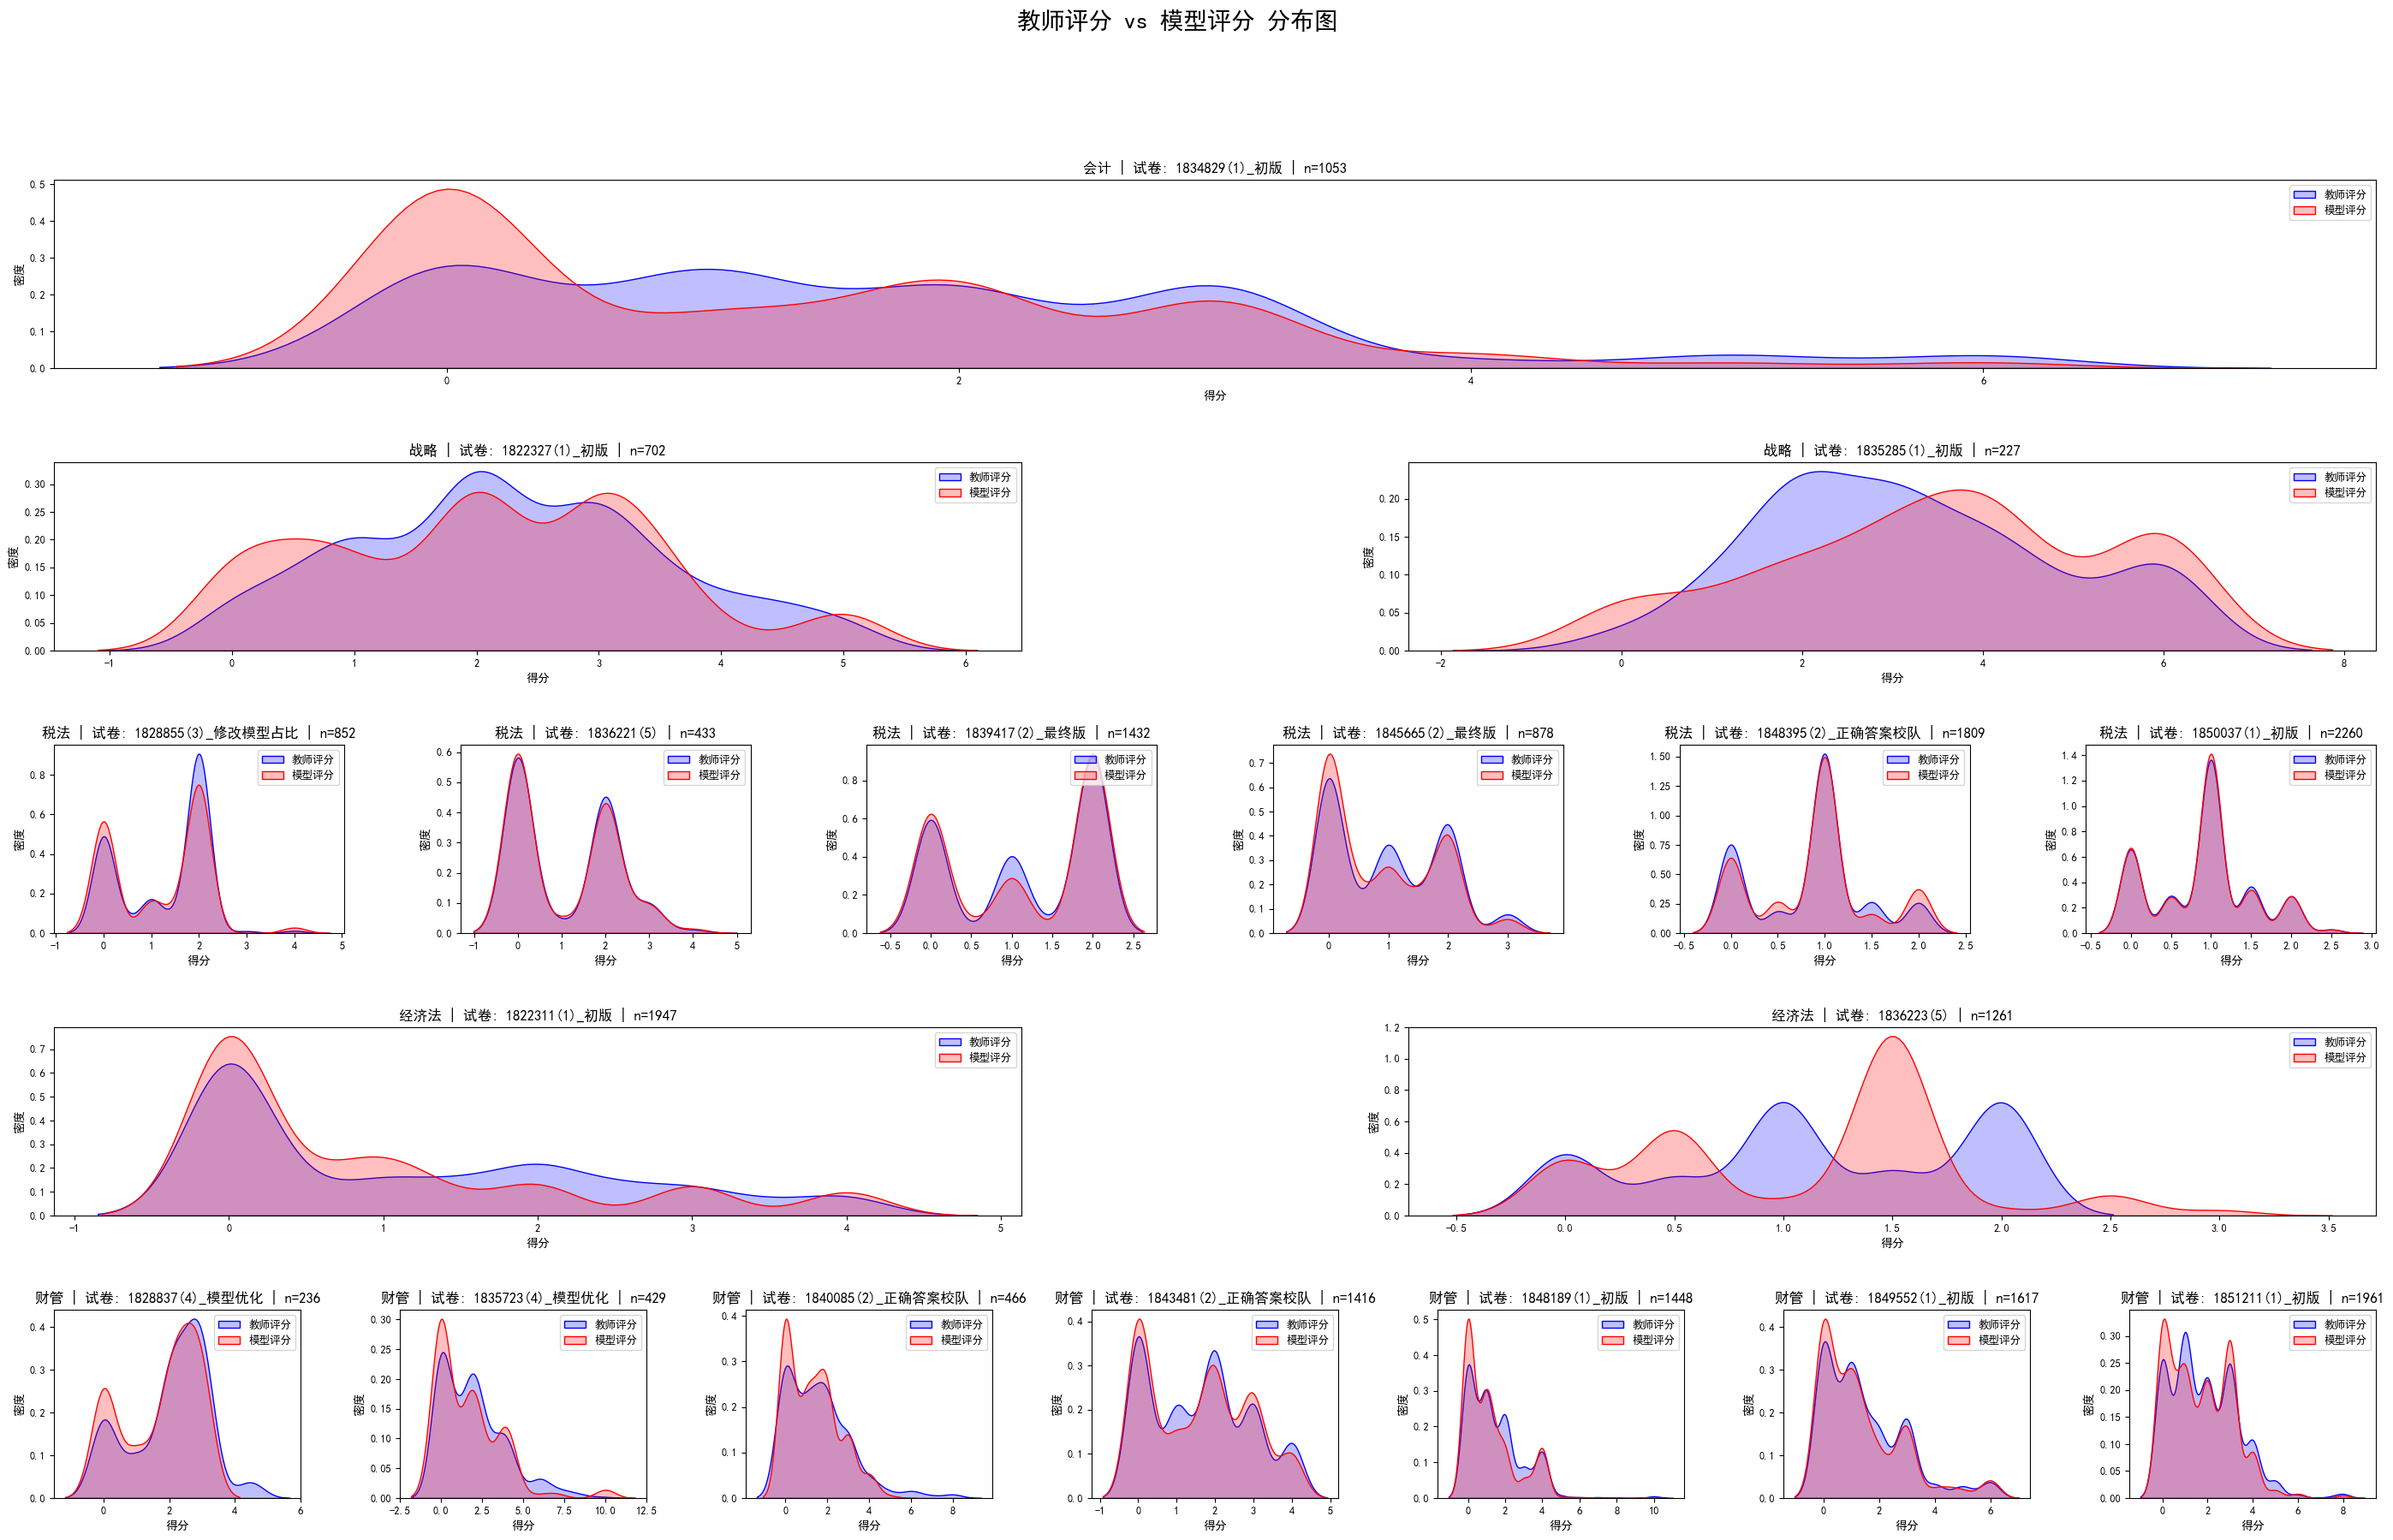

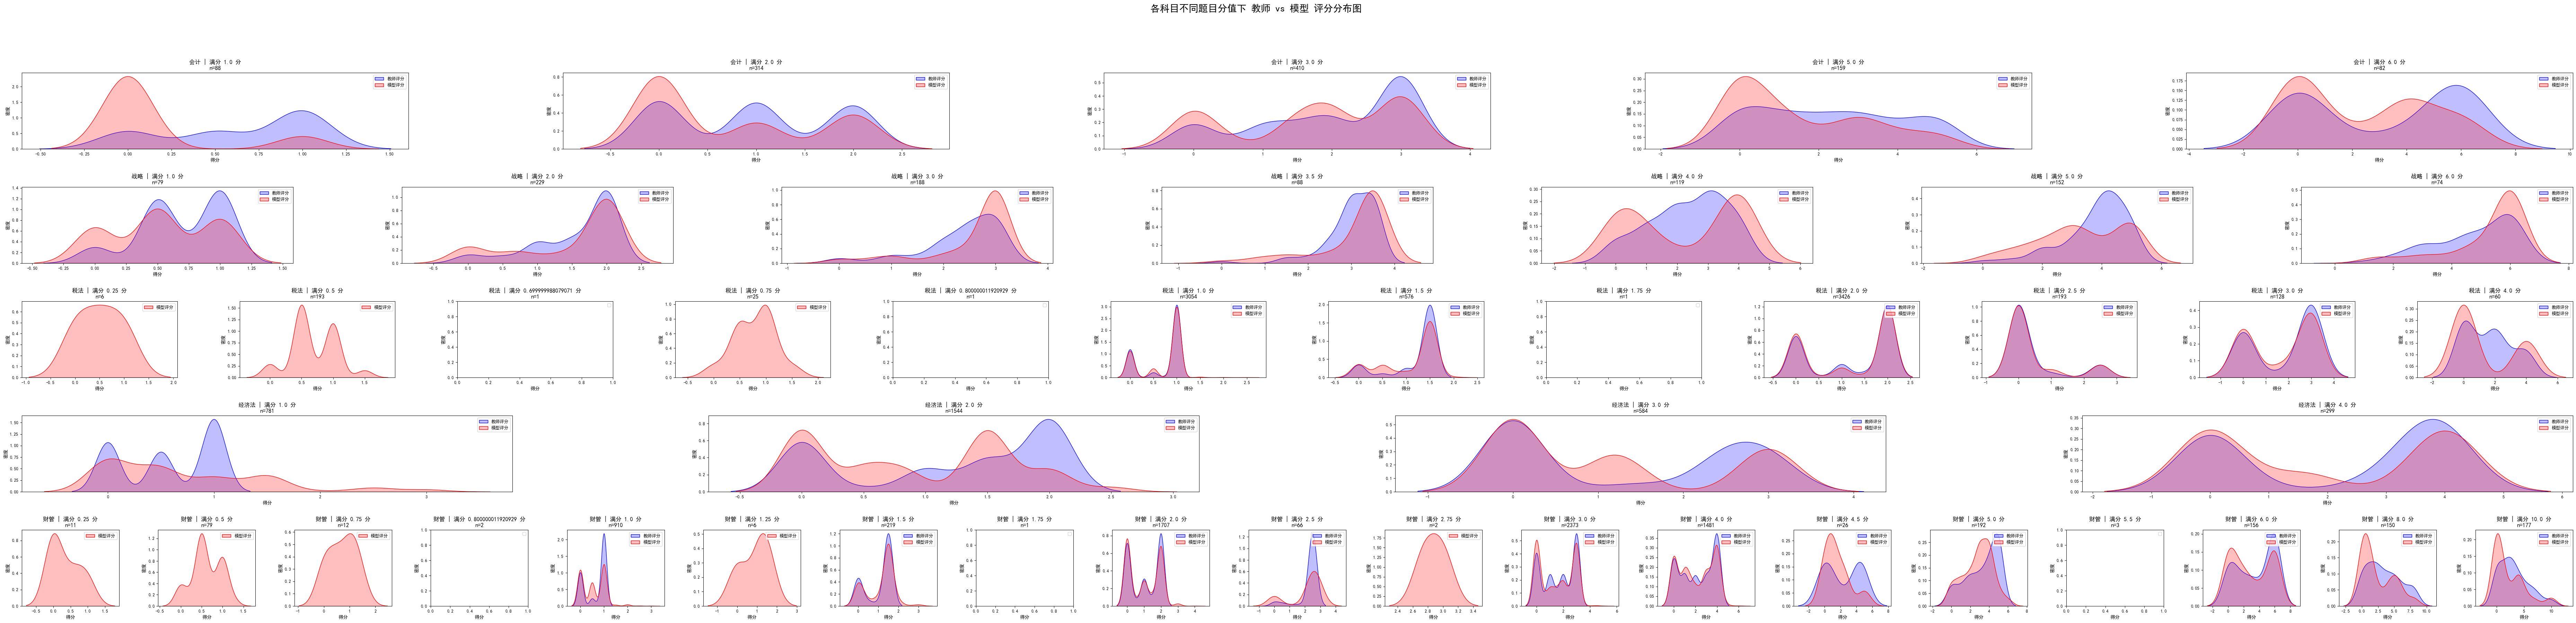

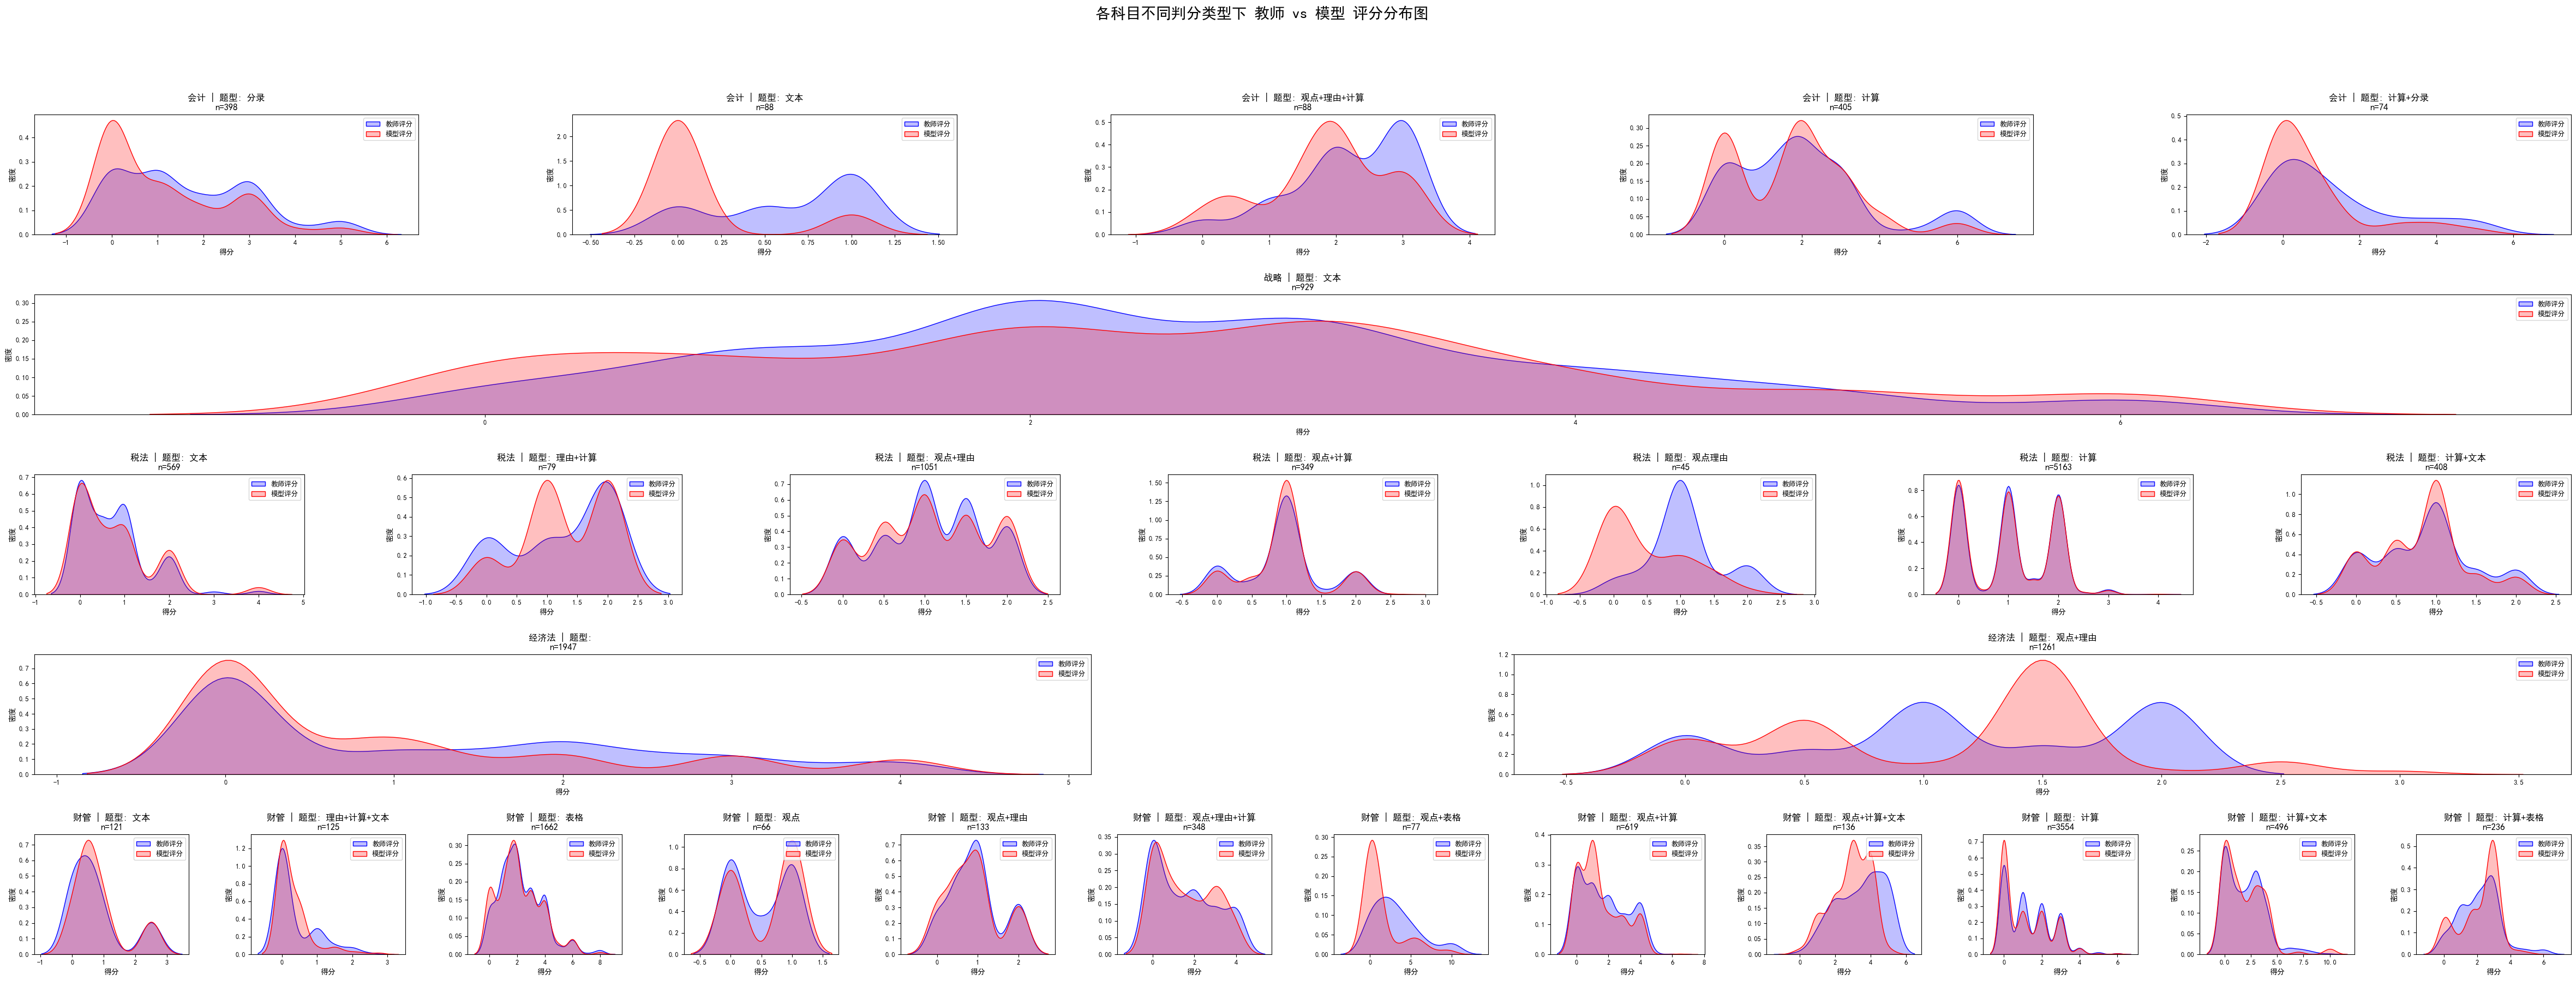

In [11]:
########### 生成html文件 ##############

# 设置输出目录
output_dir = Path("report_output")
output_dir.mkdir(exist_ok=True)

# 1. 保存所有图像
def save_all_figures(final_df1):
    """保存三种评分分布对比图"""
    # 常量定义（统一调整所有图表参数）
    STYLE = {
        'row_height': 4,          # 每行高度
        'col_width': 5,           # 每列宽度
        'title_fontsize': 20,      # 主标题字号
        'subtitle_fontsize': 12,   # 子标题字号
        'label_fontsize': 10,      # 轴标签字号
        'legend_fontsize': 9,      # 图例字号
        'tick_fontsize': 9,        # 刻度字号
        'hspace': 0.5,            # 行间距
        'wspace': 0.4,            # 列间距
        'dpi': 300,               # 输出分辨率
        'colors': {               # 颜色配置
            'teacher': ('blue', '教师评分'),
            'model': ('red', '模型评分')
        }
    }

    # 主流程
    fig_paths = []
    df = final_df1[final_df1['paper_id'].isin(paper_range)].copy()
    
    # 图表1：按试卷分布
    fig_paths.append(
        build_grid_plot(
            df, 'paper_id',
            "教师评分 vs 模型评分 分布图",
            "fig_score_dist_by_paper.png",
            STYLE,
            output_dir
        )
    )
    
    # 图表2：按题目分值分布
    fig_paths.append(
        build_grid_plot(
            df, 'question_score',
            "各科目不同题目分值下 教师 vs 模型 评分分布图",
            "fig_score_dist_by_question_score.png",
            STYLE,
            output_dir
        )
    )
    
    # 图表3：按判分类型分布
    fig_paths.append(
        build_grid_plot(
            df, 'question_type',
            "各科目不同判分类型下 教师 vs 模型 评分分布图",
            "fig_score_dist_by_question_type.png",
            STYLE,
            output_dir
        )
    )
    
    return fig_paths

fig_paths = save_all_figures(final_df1)

# 2. 表格 HTML（你之前生成的）
table_htmls = table_html_list

# 3. 合并 HTML 结构

js_code = """
<!-- 引入 jQuery 和 Select2 -->
<script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/select2@4.1.0-rc.0/dist/css/select2.min.css" rel="stylesheet" />
<script src="https://cdn.jsdelivr.net/npm/select2@4.1.0-rc.0/dist/js/select2.min.js"></script>

<script>
$(document).ready(function () {
    // 初始化 Select2
    $('.subject-filter').each(function () {
        $(this).select2({
            placeholder: "请选择科目",
            allowClear: true,
            width: '200px'
        });
    });

    // 绑定 change 事件
    $(document).on('change', '.subject-filter', function () {
        const selectedSubjects = $(this).val(); // 获取选中的值数组
        const tableId = this.id.replace('filter-', '');
        const table = document.getElementById(tableId);

        if (!table) {
            console.error(`Table with id ${tableId} not found`);
            return;
        }

        const rows = table.querySelectorAll('tbody tr');
        rows.forEach(row => {
            const subject = row.getAttribute('data-subject');

            if (!selectedSubjects || selectedSubjects.length === 0 || !subject || selectedSubjects.includes(subject)) {
                row.style.display = '';
            } else {
                row.style.display = 'none';
            }
        });
    });
});
</script>
"""

full_html = """
<!DOCTYPE html>
<html lang="zh">
<head>
    <meta charset="UTF-8">
    <title>主观题评分误差分析报告</title>
    <style>
        body { 
            font-family: "Microsoft YaHei", 
            sans-serif; 
            padding: 40px 40px 40px 220px;
            line-height: 1.6; 
            box-sizing: border-box; /* 确保padding不会增加元素的实际宽度或高度 */
            position: relative;
        }
        h1 { margin-top: 0; }
        h2 { 
            margin-top: 40px; 
            padding-top: 20px; 
            scroll-margin-top: 120px; /* 防止目录遮挡 */
        }
        img { max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; }
        label { margin-right: 10px; }
        select.subject-filter { padding: 5px; font-size: 14px; }
        .table-section { margin-bottom: 30px; }
        
        /* 新增目录样式 - 简洁不突兀 */
        .toc-wrapper {
            position: fixed;
            left: 10px;
            top: 20px;
            width: 180px;
            max-height: 90vh;
            overflow-y: auto;
            background: rgba(255,255,255,0.9);
            padding: 15px;
            border-radius: 5px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.05);
            z-index: 100;
        }
        
        .toc-title {
            font-size: 15px;
            font-weight: bold;
            margin-bottom: 10px;
            color: #333;
        }
        
        .toc-nav ul {
            list-style: none;
            padding-left: 0;
            margin: 0;
        }
        
        .toc-nav li {
            margin-bottom: 6px;
        }
        
        .toc-nav a {
            display: block;
            padding: 4px 8px;
            color: #555;
            text-decoration: none;
            font-size: 13px;
            border-left: 3px solid transparent;
            transition: all 0.2s;
        }
        
        .toc-nav a:hover {
            color: #1a73e8;
            border-left-color: #1a73e8;
        }
        
        .toc-nav a.active {
            color: #1a73e8;
            font-weight: bold;
            border-left-color: #1a73e8;
            background: rgba(26,115,232,0.05);
        }
    </style>
</head>
<body>
    <h1>主观题评分误差分析报告</h1>
    <p>本报告汇总了模型评分与教师评分在多个维度下的误差统计分析，包括不同试卷、题型、分值下的分布可视化和一致性对比。</p>
    
    <div class="toc-wrapper">
        <nav class="toc-nav">
            <ul>
                <li><a href="#base_desc">试卷基本情况描述统计</a></li>
                <li><a href="#error_desc">试卷整体误差描述统计</a></li>
                <li><a href="#acc_desc">判分准确性各项指标</a></li>
                <li><a href="#score_level_desc">分数段层面准确率</a></li>
                <li><a href="#ques_type_desc">题型层面准确率</a></li>
                <li><a href="#final_desc">最终准确率结果（小题层面）</a></li>
            </ul>
        </nav>
    </div>
"""

for section in table_htmls:
    full_html += section

# 添加图片部分
full_html += "<h2 id='fig-section'>不同条件下两者打分对比</h2>"
for fig_path in fig_paths:
    full_html += f'<img src="{fig_path.name}" alt="图表">'

# 筛选功能
full_html += js_code

# 目录跟随滚动功能
full_html += """
<script>
    // 平滑滚动和高亮功能
    document.addEventListener('DOMContentLoaded', function() {
        const links = document.querySelectorAll('.toc-link');
        const sections = document.querySelectorAll('h2[id]');
        
        // 点击目录平滑滚动
        links.forEach(link => {
            link.addEventListener('click', function(e) {
                e.preventDefault();
                const target = document.querySelector(this.getAttribute('href'));
                if (target) {
                    window.scrollTo({
                        top: target.offsetTop - 20,
                        behavior: 'smooth'
                    });
                }
            });
        });
        
        // 滚动时自动高亮
        function updateActiveLink() {
            let current = '';
            const scrollPos = window.scrollY + 100;
            
            sections.forEach(section => {
                const sectionTop = section.offsetTop;
                if (scrollPos >= sectionTop) {
                    current = section.getAttribute('id');
                }
            });
            
            links.forEach(link => {
                link.classList.remove('active');
                if (link.getAttribute('href') === '#' + current) {
                    link.classList.add('active');
                }
            });
        }
        
        // 优化滚动性能
        let isScrolling;
        window.addEventListener('scroll', function() {
            clearTimeout(isScrolling);
            isScrolling = setTimeout(updateActiveLink, 50);
        });
        
        // 初始化
        updateActiveLink();
    });
</script>
</body>
</html>
"""

# 4. 写入 HTML 文件
html_path = output_dir / "report.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(full_html)

print(f"✅ 报告已生成：{html_path.resolve()}")
